<a href="https://colab.research.google.com/github/sidhu2690/GEANT4/blob/main/HGCAL_hexa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

# =====================================================
# Parameters
# =====================================================
hexSize = 2.5  # cm (distance from center to vertex)
innerRadius = 50.0  # cm
outerRadius = 100.0  # cm

# =====================================================
# Hexagon Geometry Functions
# =====================================================
def hexagon_corners(x_center, y_center, size):
    """Returns the 6 corners of a flat-top hexagon"""
    angles = np.linspace(0, 2*np.pi, 7)  # 0, 60, 120, 180, 240, 300, 360
    corners = []
    for angle in angles:
        x = x_center + size * np.cos(angle)
        y = y_center + size * np.sin(angle)
        corners.append([x, y])
    return np.array(corners)

def generate_hexagonal_grid(hex_size, r_min, r_max):
    """
    Generate hexagonal grid centers in annular region
    Using axial coordinate system for hexagons
    """
    positions = []

    # Hexagon geometry (flat-top orientation)
    width = 2 * hex_size
    height = np.sqrt(3) * hex_size

    # Horizontal and vertical spacing
    horiz_spacing = 1.5 * hex_size
    vert_spacing = height

    # Determine search range
    max_range = int(r_max / hex_size) + 2

    # Generate hexagons in offset grid pattern
    for row in range(-max_range, max_range + 1):
        for col in range(-max_range, max_range + 1):
            # Calculate hexagon center
            x = col * horiz_spacing
            # Offset every other column
            y = row * vert_spacing + (col % 2) * (vert_spacing / 2)

            # Check if hexagon center is in annular region
            r = math.sqrt(x**2 + y**2)

            # Use a slightly relaxed condition to catch edge hexagons
            if r_min - hex_size <= r <= r_max + hex_size:
                # Check if hexagon has any overlap with annular region
                # by checking if any corner or center is in the region
                in_region = False

                # Check center
                if r_min <= r <= r_max:
                    in_region = True
                else:
                    # Check corners
                    corners = hexagon_corners(x, y, hex_size)
                    for corner in corners[:-1]:  # Last corner = first corner
                        r_corner = np.sqrt(corner[0]**2 + corner[1]**2)
                        if r_min <= r_corner <= r_max:
                            in_region = True
                            break

                if in_region:
                    positions.append((x, y, row, col))

    return np.array(positions)

def find_hexagon_cell(x_hit, y_hit, hex_size):
    """
    Find which hexagonal cell contains the hit point
    Returns the hexagon center coordinates
    """
    # Hexagon geometry
    horiz_spacing = 1.5 * hex_size
    vert_spacing = np.sqrt(3) * hex_size

    # Estimate which column and row
    col_estimate = round(x_hit / horiz_spacing)
    row_estimate = round((y_hit - (col_estimate % 2) * (vert_spacing / 2)) / vert_spacing)

    # Check this hexagon and neighbors to find closest
    best_hex = None
    min_dist = float('inf')

    for dc in range(-1, 2):
        for dr in range(-1, 2):
            col = col_estimate + dc
            row = row_estimate + dr

            x_hex = col * horiz_spacing
            y_hex = row * vert_spacing + (col % 2) * (vert_spacing / 2)

            dist = math.sqrt((x_hit - x_hex)**2 + (y_hit - y_hex)**2)

            if dist < min_dist:
                min_dist = dist
                best_hex = (x_hex, y_hex, row, col)

    return best_hex[:2]  # Return only x, y

Total number of hexagonal cells: 1602
Hexagon size: 2.5 cm
Detector region: 50.0-100.0 cm radius
--------------------------------------------------


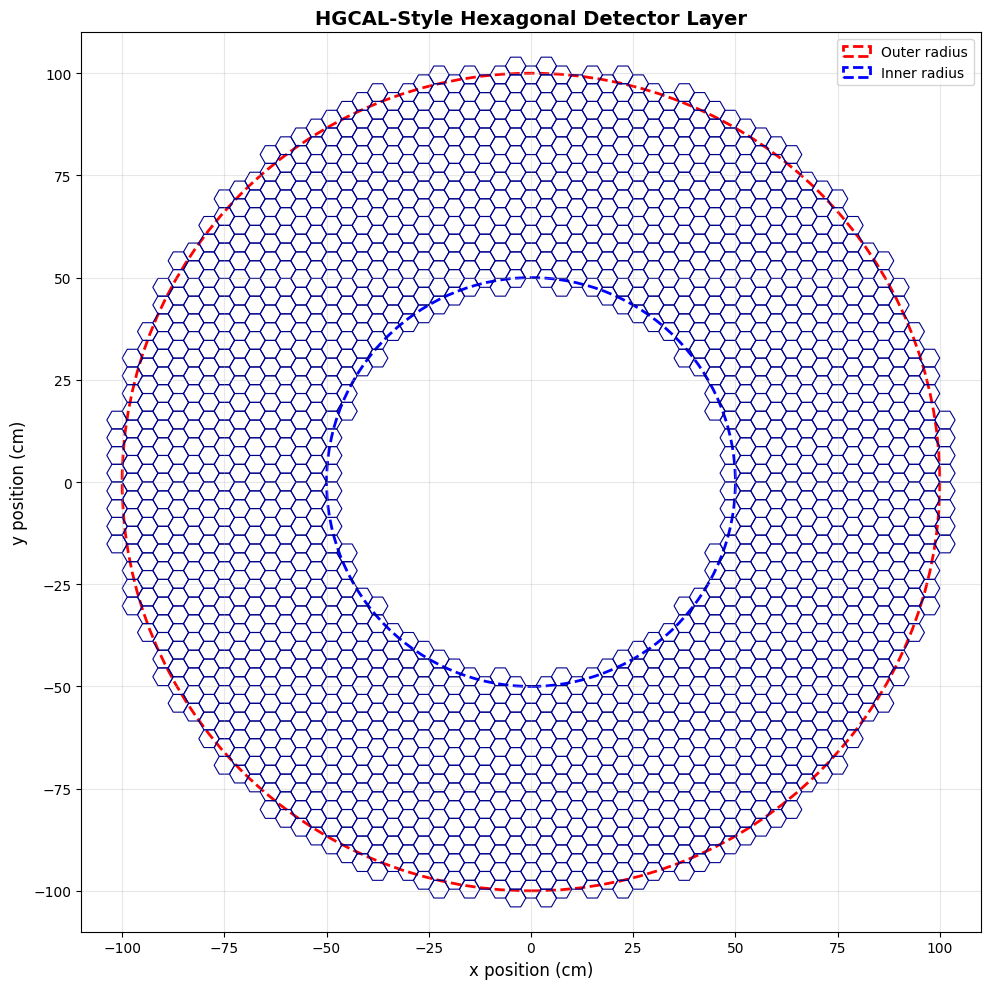

In [19]:
# =====================================================
# Generate Hexagonal Grid
# =====================================================
positions = generate_hexagonal_grid(hexSize, innerRadius, outerRadius)
print(f"Total number of hexagonal cells: {len(positions)}")
print(f"Hexagon size: {hexSize} cm")
print(f"Detector region: {innerRadius}-{outerRadius} cm radius")
print('-' * 50)

# =====================================================
# Plot All Hexagonal Cells
# =====================================================
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-outerRadius - 10, outerRadius + 10)
ax.set_ylim(-outerRadius - 10, outerRadius + 10)
ax.set_title("HGCAL-Style Hexagonal Detector Layer", fontsize=14, fontweight='bold')
ax.set_xlabel("x position (cm)", fontsize=12)
ax.set_ylabel("y position (cm)", fontsize=12)
ax.grid(True, alpha=0.3)

# Draw annulus outlines
circle_outer = plt.Circle((0, 0), outerRadius, fill=False, linestyle='--',
                          color='red', linewidth=2, label='Outer radius')
circle_inner = plt.Circle((0, 0), innerRadius, fill=False, linestyle='--',
                          color='blue', linewidth=2, label='Inner radius')
ax.add_patch(circle_outer)
ax.add_patch(circle_inner)

# Draw hexagons
for x, y, _, _ in positions:
    corners = hexagon_corners(x, y, hexSize)
    hex_patch = patches.Polygon(corners[:-1], fill=False,
                               edgecolor='darkblue', linewidth=0.8)
    ax.add_patch(hex_patch)

ax.legend()
plt.tight_layout()
plt.show()

Number of hits generated: 100
--------------------------------------------------
Cell assignment accuracy: 100/100 = 100.0%


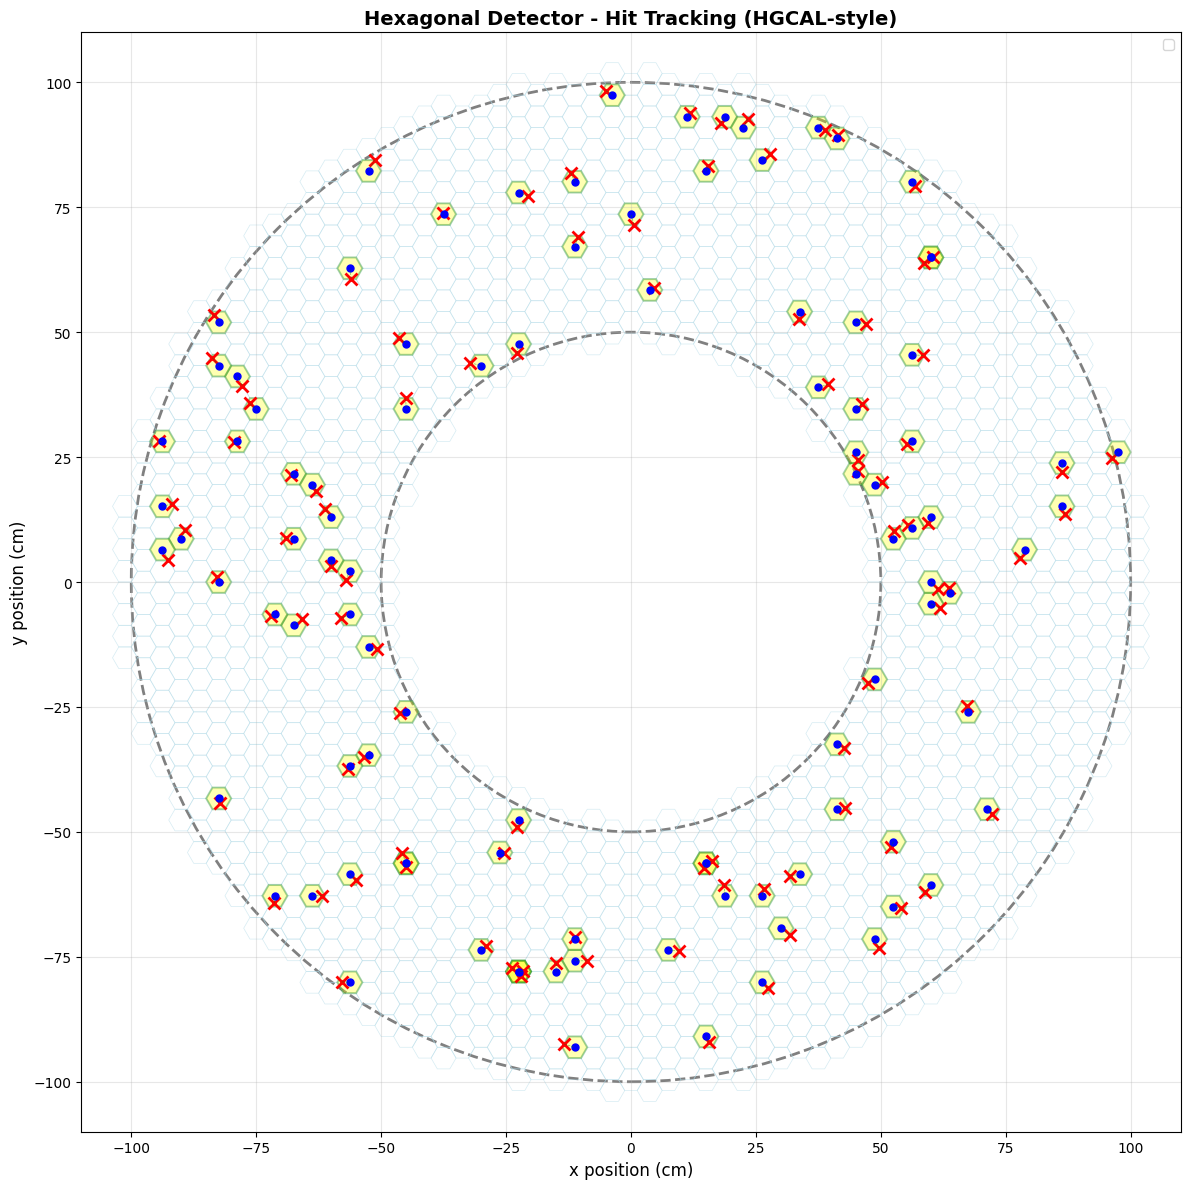


DETECTOR STATISTICS
Hexagon size (vertex): 2.5 cm
Hexagon width: 5.00 cm
Hexagon height: 4.33 cm
Total hexagonal cells: 1602
Inner radius: 50.0 cm
Outer radius: 100.0 cm
Annular area: 23561.9 cm²
Hexagon area: 16.24 cm²
Coverage efficiency: 110.4%


In [20]:
# =====================================================
# Generate Random Hits and Track Them
# =====================================================
num_hits = 100
hit_positions = []

for _ in range(num_hits):
    r_hit = np.random.uniform(innerRadius, outerRadius)
    theta_hit = np.random.uniform(0, 2 * np.pi)
    x_hit = r_hit * np.cos(theta_hit)
    y_hit = r_hit * np.sin(theta_hit)
    hit_positions.append((x_hit, y_hit))

print(f'Number of hits generated: {num_hits}')
print('-' * 50)

# =====================================================
# Plot Hits with Hexagonal Cell Assignment
# =====================================================
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-outerRadius - 10, outerRadius + 10)
ax.set_ylim(-outerRadius - 10, outerRadius + 10)
ax.set_title("Hexagonal Detector - Hit Tracking (HGCAL-style)",
             fontsize=14, fontweight='bold')
ax.set_xlabel("x position (cm)", fontsize=12)
ax.set_ylabel("y position (cm)", fontsize=12)
ax.grid(True, alpha=0.3)

# Draw annulus outlines
circle_outer = plt.Circle((0, 0), outerRadius, fill=False, linestyle='--',
                          color='gray', linewidth=2)
circle_inner = plt.Circle((0, 0), innerRadius, fill=False, linestyle='--',
                          color='gray', linewidth=2)
ax.add_patch(circle_outer)
ax.add_patch(circle_inner)

# Draw all hexagonal cells (light)
for x, y, _, _ in positions:
    corners = hexagon_corners(x, y, hexSize)
    hex_patch = patches.Polygon(corners[:-1], fill=False,
                               edgecolor='lightblue', linewidth=0.5, alpha=0.5)
    ax.add_patch(hex_patch)

# Draw hits and assigned cells
hits_inside = 0
total_hits = len(hit_positions)

for x_hit, y_hit in hit_positions:
    # Find which hexagon this hit belongs to
    x_center, y_center = find_hexagon_cell(x_hit, y_hit, hexSize)

    # Check if hit is inside the hexagon (using circumradius)
    dist_to_center = math.sqrt((x_hit - x_center)**2 + (y_hit - y_center)**2)
    inside_hex = dist_to_center <= hexSize  # Simplified check

    if inside_hex:
        hits_inside += 1

    # Draw hit as red cross
    ax.plot(x_hit, y_hit, 'x', color='red', markersize=8,
            markeredgewidth=2, label='Hit' if _ == 0 else '')

    # Draw hexagon center as blue dot
    ax.plot(x_center, y_center, 'o', color='blue', markersize=5,
            label='Cell center' if _ == 0 else '')

    # Draw assigned hexagon (highlighted)
    corners = hexagon_corners(x_center, y_center, hexSize)
    hex_patch = patches.Polygon(corners[:-1], fill=True,
                               edgecolor='green', facecolor='yellow',
                               linewidth=1.5, alpha=0.3)
    ax.add_patch(hex_patch)

    # Draw line from hit to cell center
    ax.plot([x_hit, x_center], [y_hit, y_center], 'g--',
            linewidth=0.5, alpha=0.5)

accuracy = (hits_inside / total_hits) * 100
print(f'Cell assignment accuracy: {hits_inside}/{total_hits} = {accuracy:.1f}%')

# Remove duplicate labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()

# =====================================================
# Statistics
# =====================================================
print('\n' + '='*50)
print('DETECTOR STATISTICS')
print('='*50)
print(f'Hexagon size (vertex): {hexSize} cm')
print(f'Hexagon width: {2*hexSize:.2f} cm')
print(f'Hexagon height: {np.sqrt(3)*hexSize:.2f} cm')
print(f'Total hexagonal cells: {len(positions)}')
print(f'Inner radius: {innerRadius} cm')
print(f'Outer radius: {outerRadius} cm')
print(f'Annular area: {np.pi*(outerRadius**2 - innerRadius**2):.1f} cm²')
print(f'Hexagon area: {(3*np.sqrt(3)/2)*hexSize**2:.2f} cm²')
print(f'Coverage efficiency: {len(positions)*(3*np.sqrt(3)/2)*hexSize**2 / (np.pi*(outerRadius**2 - innerRadius**2))*100:.1f}%')
print('='*50)